<a href="https://colab.research.google.com/github/AkshitAggarwal/Time_Series_Forecasting_Hopitalisations/blob/main/Covid_Hospitalizations_Minor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from tqdm import tqdm

In [2]:
dataset = pd.read_csv("Data_Minor_test.csv",parse_dates=True,dayfirst=True,index_col=0)
dataset.index.freq='D'
testset = pd.read_csv("UK-Final.csv",parse_dates=True,dayfirst=True,index_col=0)
testset.index.freq='D'

In [3]:
testset.head()

,Beds Occupied
Date,
2020-03-28,8278
2020-03-29,9525
2020-03-30,11093
2020-03-31,12597
2020-04-01,13637


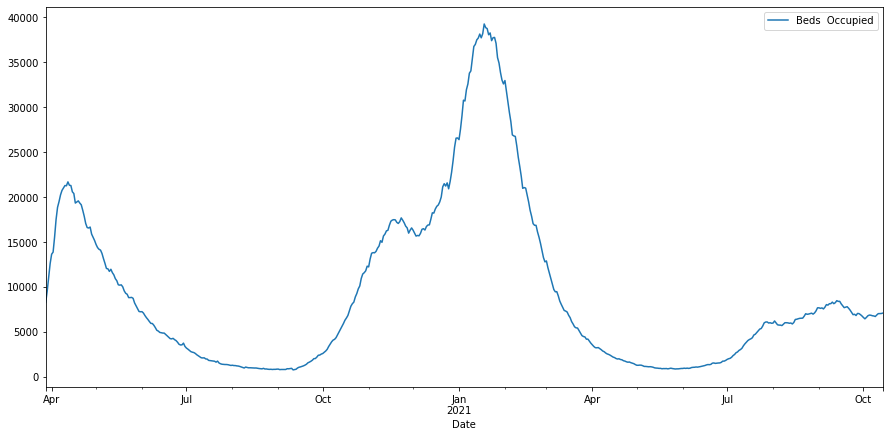

In [4]:
testset.plot(figsize=(15,7))

In [5]:
train = testset
test = testset

In [6]:
train = testset[:int(len(testset)*0.8)]['Beds  Occupied'].values.reshape(-1, 1)
test = testset[int(len(testset)*0.8):]['Beds  Occupied'].values.reshape(-1, 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

In [8]:
scaler.fit(train) 
# scaler2.fit(test['Beds  Occupied'].values.reshape(-1, 1))
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
max(scaled_train)

array([1.])

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
target_size = 5
targets_temp = list(scaled_train[:target_size])
targets_train = [deepcopy(targets_temp)]
for i in range(target_size, len(scaled_train)):
    targets_temp.append(scaled_train[i])
    targets_train.append(targets_temp[-target_size:])

In [12]:
n_input = 20
n_features = 1
generator = TimeseriesGenerator(scaled_train[:len(targets_train)], targets_train, length=n_input, batch_size=8)

In [13]:
# X , y = generator[1]
# print(f'Given the Array: \n{X}')
# print(f'Predict this y: \n {y}')

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [15]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(target_size))
model.compile(optimizer='adam', loss='mse')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 30,855
Trainable params: 30,855
Non-trainable params: 0
_________________________________________________________________


In [28]:
# fit model
model.fit(generator,epochs=100)

Epoch 1/100
54/54 [==============================] - 1s 17ms/step - loss: 7.1554e-04
Epoch 2/100
54/54 [==============================] - 1s 17ms/step - loss: 4.6515e-04
Epoch 3/100
54/54 [==============================] - 1s 17ms/step - loss: 2.6127e-04
Epoch 4/100
54/54 [==============================] - 1s 17ms/step - loss: 2.9987e-04
Epoch 5/100
54/54 [==============================] - 1s 17ms/step - loss: 4.7535e-04
Epoch 6/100
54/54 [==============================] - 1s 17ms/step - loss: 3.9083e-04
Epoch 7/100
54/54 [==============================] - 1s 17ms/step - loss: 5.3448e-04
Epoch 8/100
54/54 [==============================] - 1s 16ms/step - loss: 4.5438e-04
Epoch 9/100
54/54 [==============================] - 1s 17ms/step - loss: 0.0012
Epoch 10/100
54/54 [==============================] - 1s 17ms/step - loss: 9.1078e-04
Epoch 11/100
54/54 [==============================] - 1s 16ms/step - loss: 6.0376e-04
Epoch 12/100
54/54 [==============================] - 1s 17ms/step 

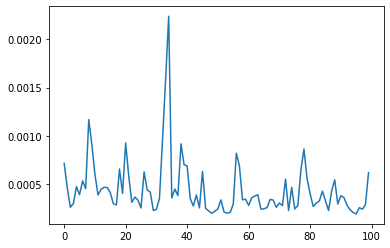

In [29]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [30]:
last_train_batch = scaled_train[-20:]

In [31]:
#last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [32]:
#model.predict(last_train_batch)

In [33]:
scaled_test[0]

array([0.01886498])

In [34]:
test_predictions = []
optimistic = []
optimistic_preds = []
first_eval_batch = scaled_test[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in tqdm(range(len(test) - n_input)):
    # print(scaled_test[i:i+n_input])
    
    # print(inp)
    current_pred = model.predict(scaled_test[i:i+n_input].reshape((1, n_input, n_features)))[0]
    test_predictions.append(current_pred[0]) 

optimistic = list(scaled_test[-n_input:]) 
future_preds = 20
for i in range(future_preds):
    # Future forecasting
    inp = np.array(optimistic[-n_input:])
    opt_pred = model.predict(inp.reshape((1, n_input, n_features)))[0]
    optimistic_preds.append(opt_pred[0])
    # print(opt_pred)
    optimistic.append(np.array([optimistic_preds[-1]]))
    # current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

100%|██████████| 94/94 [00:04<00:00, 20.79it/s]


In [35]:
true_predictions = scaler.inverse_transform([test_predictions])

In [36]:
np.array(scaler.inverse_transform([optimistic_preds])).reshape(1, -1)

array([[7179.64134991, 7264.58570939, 7351.20341432, 7426.57621491,
        7502.45939159, 7585.08985496, 7677.4415493 , 7782.98961973,
        7899.83133829, 8016.06978083, 8128.75279438, 8243.02657568,
        8363.17713702, 8491.26203954, 8628.43622422, 8773.52869332,
        8916.4764359 , 9059.00784922, 9206.83914554, 9359.78796577]])

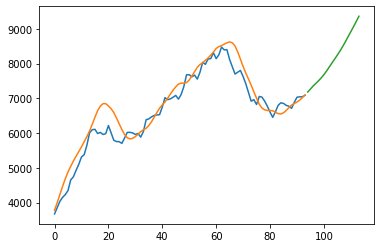

In [37]:
plt.plot(test[n_input:].reshape(1, -1)[0])
plt.plot(true_predictions[:][0])
plt.plot((range(len(true_predictions[0]), future_preds + len(true_predictions[0]))),np.array(scaler.inverse_transform([optimistic_preds])).reshape(1, -1)[0])

In [40]:
from sklearn.metrics import mean_squared_error

print( mean_squared_error( scaled_test[n_input:].reshape(1, -1)[0] , test_predictions ) )

7.789415328200837e-05
